In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Data/Variants/Infected/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files['대구']
data

,stdDay,incDec,alpha_variants,delta_variants
0,2021-04-12,16.0,4.16,0.32
1,2021-04-13,9.0,2.34,0.18
2,2021-04-14,11.0,2.86,0.22
3,2021-04-15,18.0,4.68,0.36
4,2021-04-16,4.0,1.04,0.08
...,...,...,...,...
121,2021-08-11,66.0,0.66,62.70
122,2021-08-12,39.0,0.39,37.05
123,2021-08-13,57.0,0.57,54.15
124,2021-08-14,82.0,0.82,77.90


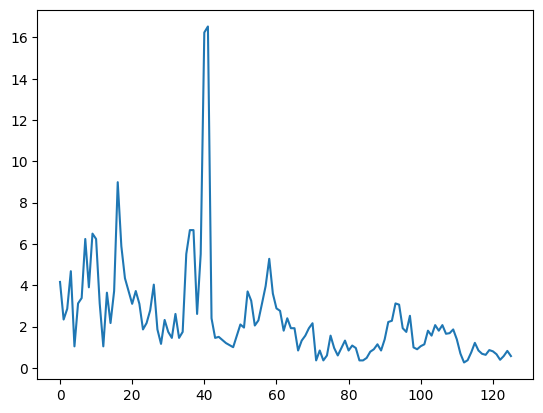

In [3]:
plt.plot(data['alpha_variants'])

In [4]:
path = 'hyperparameter/Infected/alpha/*.pkl'
files = glob.glob(path)
dic_hyperparameter = {}
for file in files:
    dic_hyperparameter[file[30:-4]] = load_hyperparameter(file)
    
dic_hyperparameter

{'BiGRU': [539, 1e-05, 50, 2, 64, 8, 0.25],
 'BiLSTM': [332, 0.0001, 50, 4, 32, 16, 0.25],
 'BiRNN': [643, 1e-05, 50, 8, 32, 32, 0.25],
 'GRU': [508, 0.0001, 50, 4, 32, 32, 0.25],
 'LSTM': [450, 0.001, 50, 4, 32, 16, 0.25],
 'RNN': [407, 0.001, 50, 4, 64, 32, 0.25],
 'seq2seq_BiGRU': [434,
  0.001,
  20,
  1,
  32,
  16,
  0.25,
  <function utils.criterion2(actual, predict)>],
 'seq2seq_BiLSTM': [461,
  0.001,
  50,
  2,
  32,
  8,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_BiRNN': [572,
  0.001,
  50,
  4,
  32,
  8,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_GRU': [1298,
  0.001,
  50,
  2,
  64,
  16,
  0.25,
  <function utils.criterion2(actual, predict)>],
 'seq2seq_LSTM': [1237,
  0.001,
  50,
  2,
  64,
  16,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_RNN': [1039,
  0.001,
  50,
  2,
  32,
  32,
  0.25,
  <function utils.criterion2(actual, predict)>]}

In [5]:
dic_model = load_model_multiple(dic_hyperparameter, 'Infected', 'alpha')

In [6]:
df = Prepare_df.processing(data, 'stdDay', 'alpha_variants')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

predicted_values = {}
num_model = 0
for name, state in dic_model.items():
    batch_size = dic_hyperparameter[name][4]
    if num_model < 6:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 57, 60, 1, batch_size, 'mto')
        label_y, predicted = predict_mto(state, df, x_ss, y_ms)
        predicted_values[name] = [label_y, predicted]
    else:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 51, 60, 7, batch_size, 'mtm')
        label_y, predicted, first_label_y, first_predicted, all_predicted = predict_mtm(state, df, x_ss, y_ms, 7, 0.5, device)
        predicted_values[name] = [label_y, predicted, first_label_y, first_predicted, all_predicted]
        
    
    num_model += 1

In [8]:
actual_data = predicted_values['RNN'][0]

0.2112238229948606


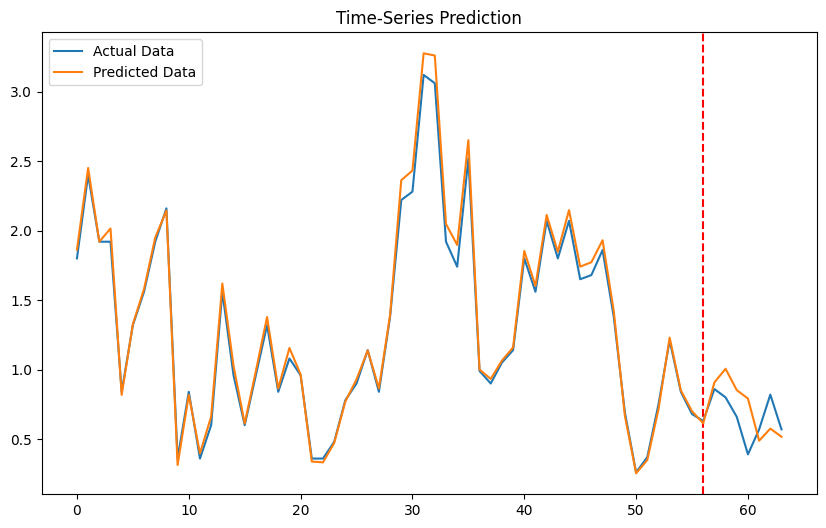

In [11]:
print(rmse(actual_data[-7:], predicted_values['RNN'][1][-7:]))
plotting(actual_data, predicted_values['RNN'][1], 56)

0.15625417822973442


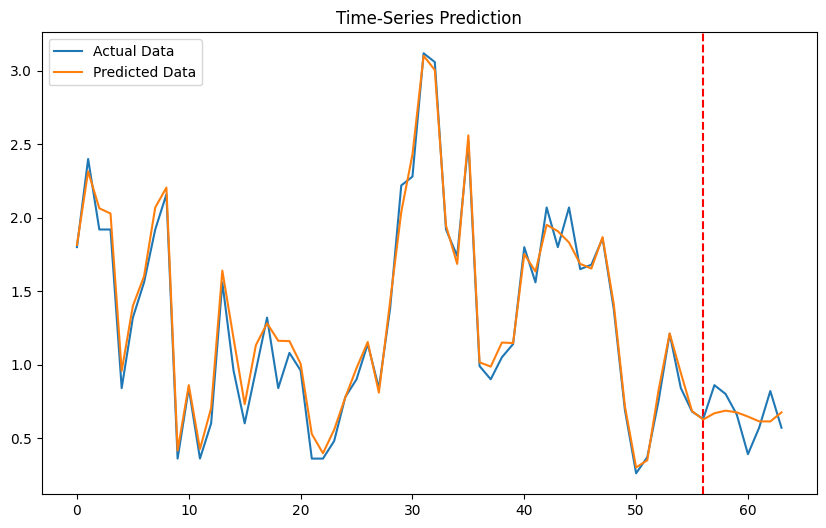

In [12]:
print(rmse(actual_data[-7:], predicted_values['LSTM'][1][-7:]))
plotting(actual_data, predicted_values['LSTM'][1], 56)

0.1850368215188857


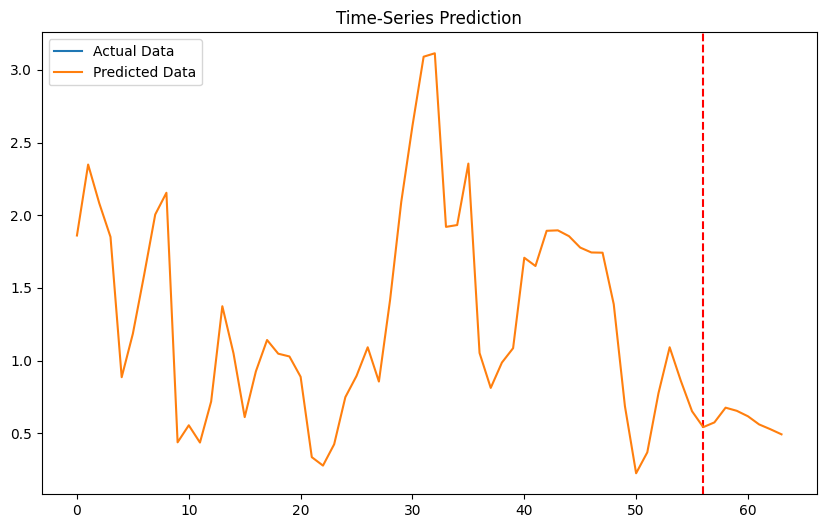

In [13]:
print(rmse(actual_data[-7:], predicted_values['GRU'][1][-7:]))
plotting(actual_data[0], predicted_values['GRU'][1], 56)

1.3484263113536754


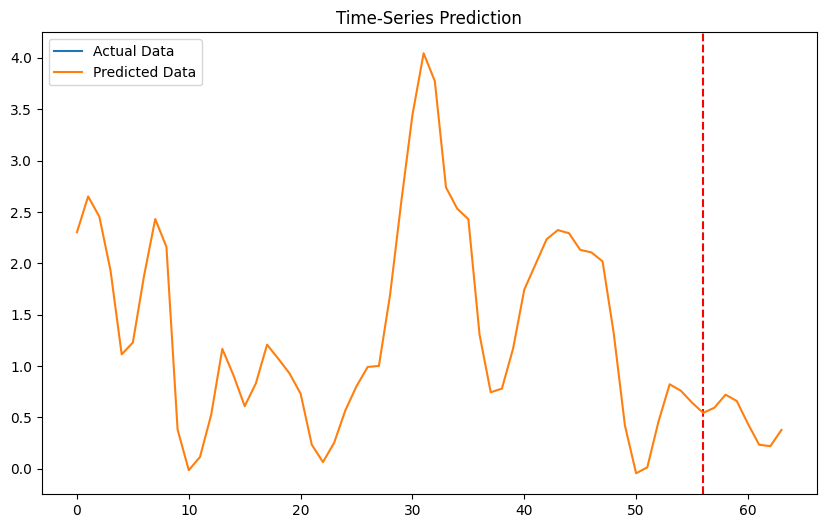

In [14]:
print(rmse(actual_data[0][-7:], predicted_values['BiRNN'][1][-7:]))
plotting(actual_data[0], predicted_values['BiRNN'][1], 56)

0.15393605476154765


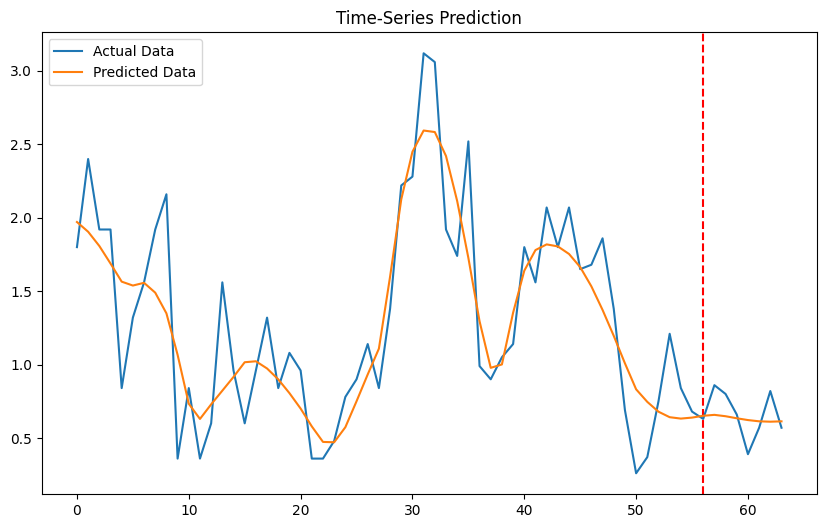

In [15]:
print(rmse(actual_data[-7:], predicted_values['BiLSTM'][1][-7:]))
plotting(actual_data, predicted_values['BiLSTM'][1], 56)

0.17796886611546187


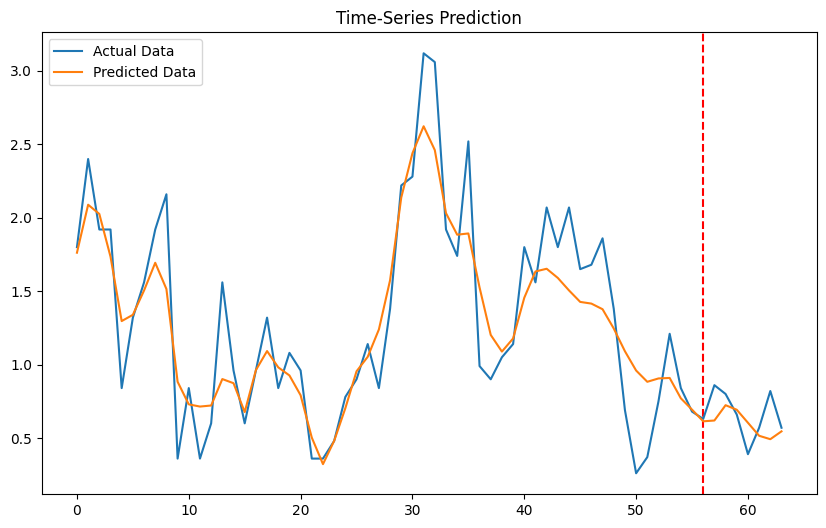

In [16]:
print(rmse(actual_data[-7:], predicted_values['BiGRU'][1][-7:]))
plotting(actual_data, predicted_values['BiGRU'][1], 56)

0.2841607051421665


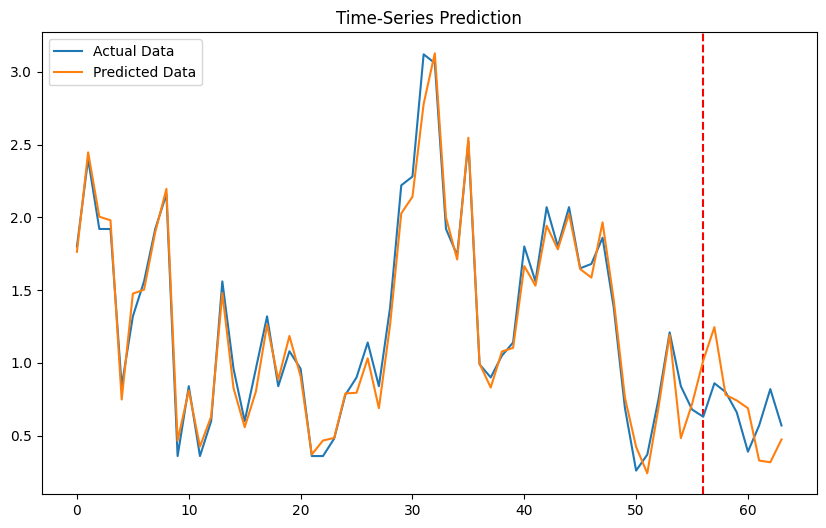

In [17]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_RNN'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_RNN'][4], 56)

0.2690209935347168


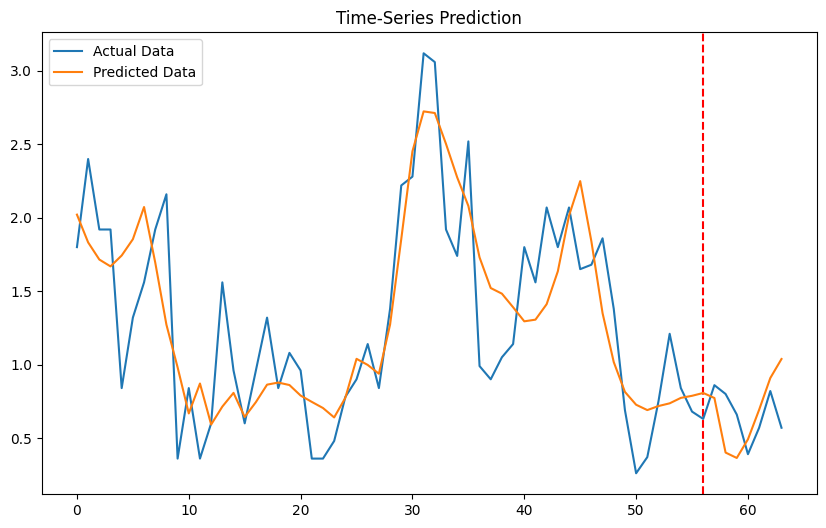

In [18]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_LSTM'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_LSTM'][4], 56)

0.286614205116791


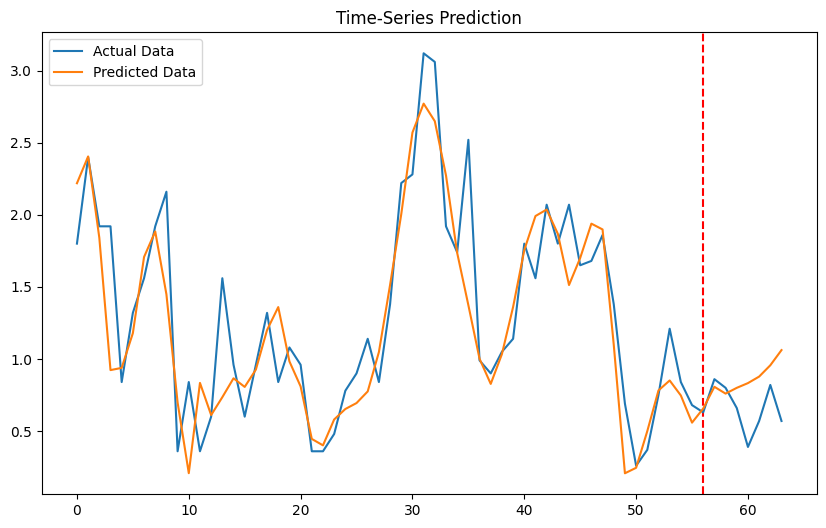

In [19]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_GRU'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_GRU'][4], 56)

0.23201319081577818


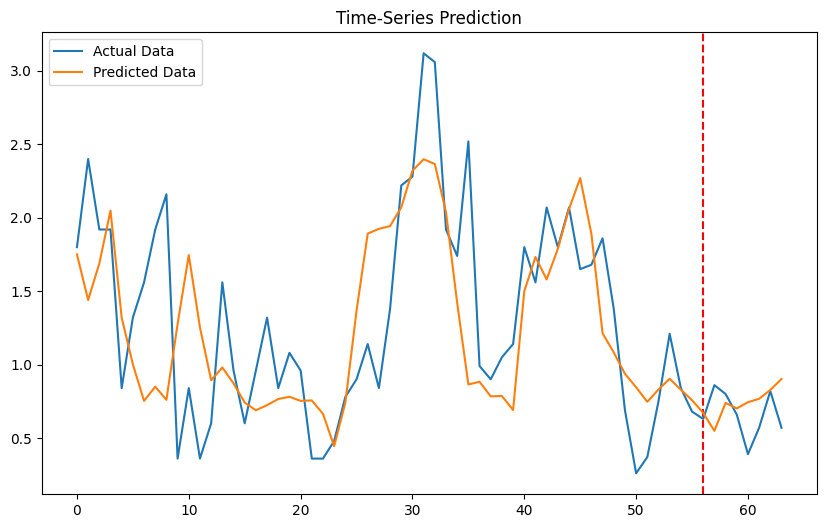

In [20]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiRNN'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiRNN'][4], 56)

0.15721595917956066


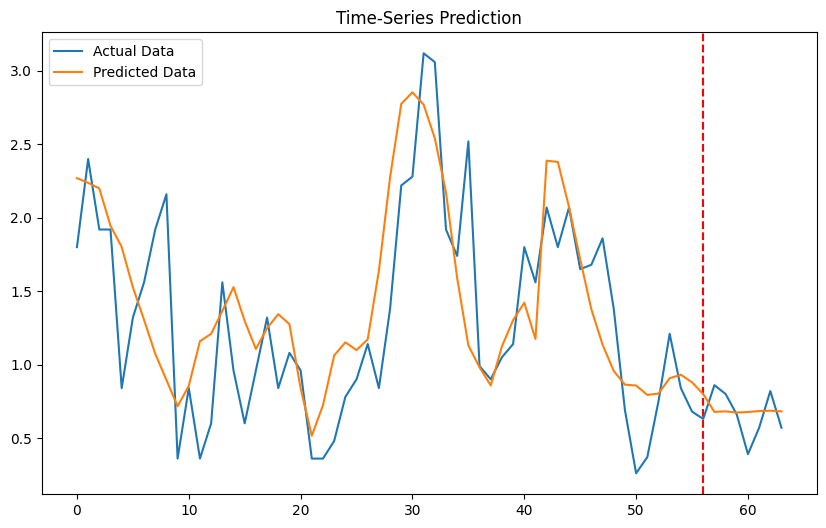

In [21]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiLSTM'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiLSTM'][4], 56)

0.18065005067668344


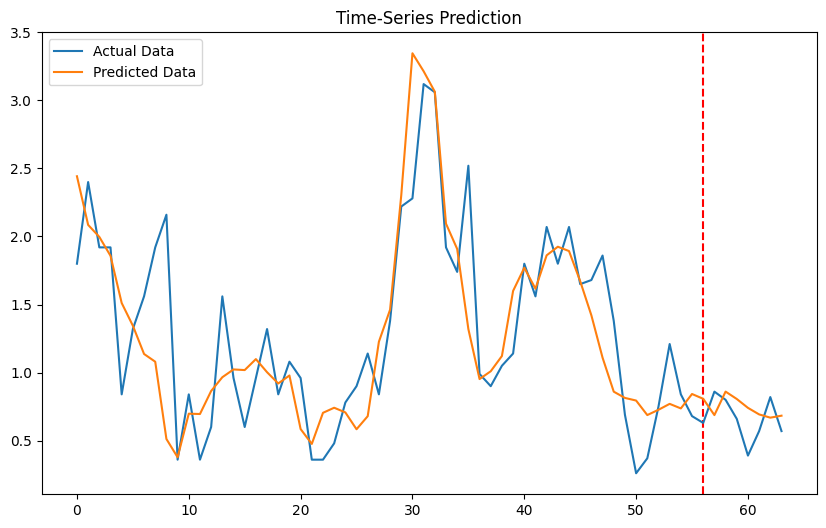

In [22]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiGRU'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiGRU'][4], 56)

In [25]:
best_model = 'BiLSTM'
datetime_index = data['stdDay'][-1*len(actual_data):]
df_predicted = pd.DataFrame()
df_predicted = pd.DataFrame(np.concatenate([actual_data, predicted_values[best_model][1]], axis = 1), 
                            index = datetime_index, 
                            columns = ['Alpha_origin', 'Alpha_Predicted'])

df_predicted.to_csv(f'Data/Predicted/Variants/Infected/alpha_{best_model}.csv')

In [26]:
df_predicted

,Alpha_origin,Alpha_Predicted
stdDay,,
2021-06-13,1.80,1.971080
2021-06-14,2.40,1.904724
2021-06-15,1.92,1.807943
2021-06-16,1.92,1.688533
2021-06-17,0.84,1.564924
...,...,...
2021-08-11,0.66,0.634585
2021-08-12,0.39,0.622334
2021-08-13,0.57,0.613830
